
Eleventh exercice: Self-calibrated CS-pMR image reconstruction from undersampled Cartesian data
==================================================================================================

In this tutorial we will reconstruct an MRI image from Cartesian undersampled kspace data. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with **self-calibrated** multi-coil Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation. The multicoil data $(y_\ell)_\ell$ is collected across multiple, say $L$, channels. The sensitivity maps $(S_\ell)_\ell$ are automically calibrated from the central portion of k-space (e.g. 5%) for all channels $\ell=1, \ldots, L$.

We remind that the synthesis formulation of the non-Cartesian CS-PMRI problem reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - F_\Omega  S_\ell \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - F_\Omega  S_\ell x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021, update: 02/13/2024
- Target: ATSI MSc students, Paris-Saclay University

In [16]:
# Package import
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors.utils.extract_sensitivity_maps \
    import get_Smaps, extract_k_space_center_and_locations
from mri.reconstructors import SelfCalibrationReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

Loading input data
---------------------------

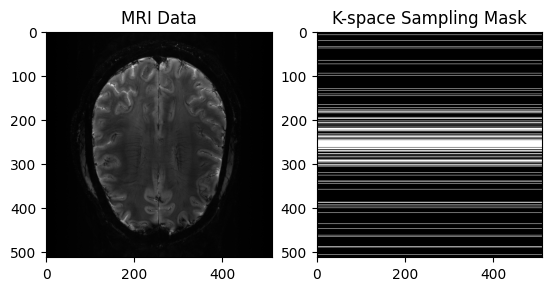

In [8]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri')
image = np.linalg.norm(cartesian_ref_image, axis=0)
# Obtain MRI cartesian mask
mask = get_sample_data("cartesian-mri-mask").data

# View Input
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

In [12]:
mask_sampled = np.where(mask==1)
print(512**2/np.size(mask_sampled))

2.6122448979591835


Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively undersample the k-space using a cartesian acquisition mask. We then reconstruct the zero order solution as a baseline


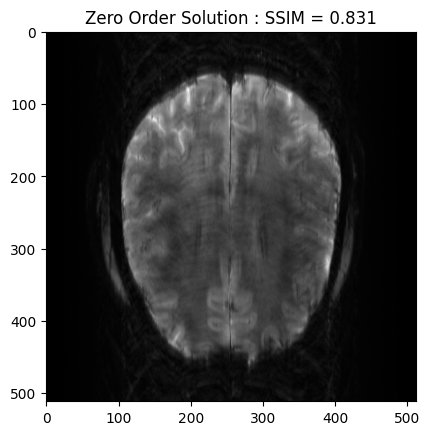

In [13]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(mask=mask, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

# %%
# Zero order solution
zero_soln = np.linalg.norm(fourier_op.adj_op(kspace_obs), axis=0)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

/srv/conda/envs/notebook/lib/python3.10/site-packages/mri/reconstructors/utils/extract_sensitivity_maps.py:86: UserWarning: Data Values seem to have rank 3 (>2). Using is_fft for now.
  warnings.warn('Data Values seem to have rank '


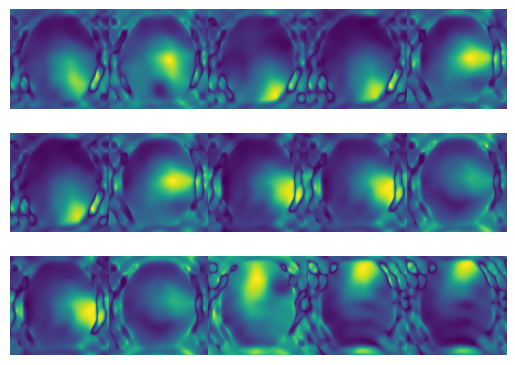

In [17]:
# Obtain SMaps
kspace_loc = convert_mask_to_locations(mask)
Smaps, SOS = get_Smaps(
    k_space=kspace_obs,
    img_shape=fourier_op.shape,
    samples=kspace_loc,
    thresh=(0.01, 0.01),    # The cutoff threshold in each kspace direction
                            # between 0 and kspace_max (0.5)
    min_samples=kspace_loc.min(axis=0),
    max_samples=kspace_loc.max(axis=0),
    mode='gridding',
    method='linear',
    n_cpu=-1,
)

h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(Smaps[3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

In [7]:
# Setup Fourier Operator with SENSE. This would initialize the
# fourier operators in the GPU.
# For this we need to specify the implementation as gpuNUFFT
# and also pass the Smaps calculated above
fourier_implementation = 'cpu'
#fourier_implementation = 'gpuNUFFT'

fourier_op_sense = NonCartesianFFT(
    samples=kspace_loc,
    shape=image.shape,
    n_coils=cartesian_ref_image.shape[0],
    smaps=Smaps,
    implementation=fourier_implementation,
)

FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost


In [5]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 1.5e-8, thresh_type="soft")

In [6]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    kspace_portion=0.01,
    verbose=1,
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/mri/reconstructors/utils/extract_sensitivity_maps.py:86: UserWarning: Data Values seem to have rank 3 (>2). Using is_fft for now.
  warnings.warn('Data Values seem to have rank '


Lipschitz constant is 1.0983752102300974
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0983752102300974
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f80d1467ca0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  286.83856094349176  seconds
----------------------------------------


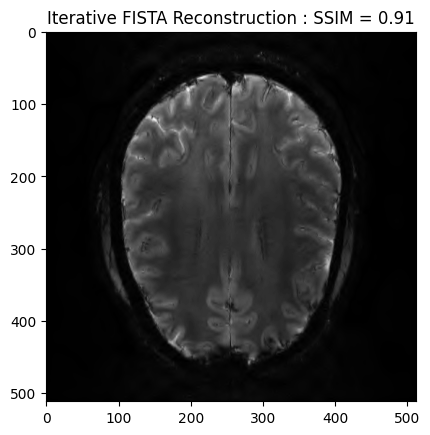

In [7]:
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative FISTA Reconstruction : SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM reconstruction

Lipschitz constant is 1.0984076316044222
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0984076316044222
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f80d1467ca0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  284.2866150448099  seconds
----------------------------------------


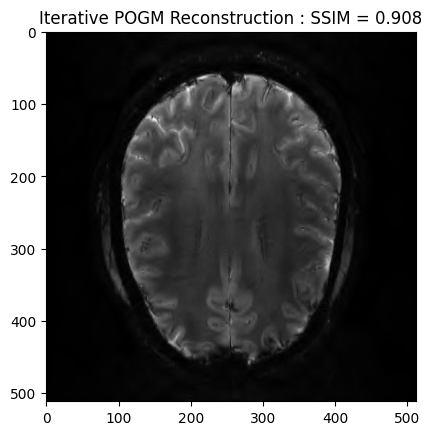

In [8]:
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative POGM Reconstruction : SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

In [39]:
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 4e-7, thresh_type="soft")

In [40]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op_sense,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

In [ ]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = {}'.format(recon_ssim))
plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.7s finished


Lipschitz constant is 377.47294091080346
The lipschitz constraint is satisfied
 - mu:  4e-07
 - lipschitz constant:  377.47294091080346
 - tau:  0.005283927166243963
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7f6f533ba8d0> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


 23% (46 of 200) |#####                  | Elapsed Time: 0:02:19 ETA:   0:07:00